In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

from dask_image import imread

from cil.framework import AcquisitionGeometry
from cil.io import ZEISSDataReader, TIFFStackReader
from cil.processors import Binner, TransmissionAbsorptionConverter
from cil.recon import FDK

### Path to Battery tiff dataset

In [2]:
path = r"Z:\Users\Antony\RSIF\microct\raw\20231006_d5_3666_AV\20231006_d5_3666_AV_overview_160kV\Projection\tiffs"

In [3]:
# data_np = TIFFStackReader(file_name = path).read() # Wall time: 3min 17s
data_np = imread.imread(os.path.join(path, "*.tif")).astype("float32").compute() # Wall time: 1min 6s


UsageError: Line magic function `%%time` not found.


In [7]:
print("Sinogram shape is {}".format(data_np.shape))

Sinogram shape is (1001, 3000, 1000)


### Setup CIL geometry

- Geometry info from P:\Antony\RSIF\microct\raw\20231006_d5_3666_AV\20231006_d5_3666_AV_overview_160kV
- 20231006_d5_3666_AV_overview_160kV.pdf

In [12]:
angles_list = np.linspace(-np.pi, np.pi, 1001)

num_pixels_y = 1000
num_pixels_x = 3000
pixel_size_y = 139/1000
pixel_size_x = 417/3000


ag = AcquisitionGeometry.create_Cone3D( source_position=[0.0, -52., 0.0], \
                                        detector_position=[+0.584, 800 , 0.],\
                                        rotation_axis_position=[0, 0., 0.],\
                                        rotation_axis_direction=[0., 0, np.pi] ) \
                        .set_angles(angles = angles_list, angle_unit='radian')\
                        .set_panel( num_pixels=[num_pixels_y, num_pixels_x], \
                                    pixel_size=[pixel_size_y, pixel_size_x],\
                                    origin='bottom-left')\
                        .set_labels(['angle','vertical','horizontal'])

### reduce ImageGeometry for efficiency, center battery
ig = ag.get_ImageGeometry()
ig.voxel_num_y = 500
ig.voxel_num_x = 500
ig.center_y = 0.35
ig.center_x = 1.00

In [13]:
data = ag.allocate()
data.fill(data_np)


In [14]:
absorb = TransmissionAbsorptionConverter()
absorb.set_input(data)
data_absorbed = absorb.get_output()

In [15]:
data_absorbed -= np.mean(data_absorbed.array[0:100,:,0:10])

In [16]:
fdk_recon = FDK(data_absorbed, image_geometry=ig).run()

FDK recon

Input Data:
	angle: 1001
	vertical: 3000
	horizontal: 1000

Reconstruction Volume:
	vertical: 3000
	horizontal_y: 500
	horizontal_x: 500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



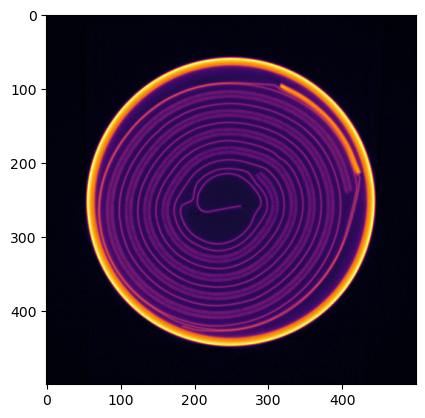

In [19]:
plt.figure()
plt.imshow(fdk_recon.array[1500], cmap="inferno")
plt.show()